# Projet -- Apprendre la structure d’un réseau bayésien
### Contexte
Un réseau bayésien est souvent construit avec l’aide d’un expert et d’une base de données. L’expert (qui parfois est simplement le décideur) peut avoir des intuitions sur les indépendances, ce qui est une cause, ce qui est plutot une conséquence. Parfois, des experts peuvent ne pas s’entendre à ce sujet. Si un expert donne la structure du réseau (i.e. il donne le graphe orienté acyclique), il n’est pas difficile de calculer les tables de probabilités conditionnelles.
Si on n’a pas d’expert pour nous aider à construire le graphe, peut-on chercher un bon graphe avec les données ? On peut dire que l’on veut apprendre la structure d’un réseau bayésien. Malheureusement, c’est un problème difficile (c’est un autre problème NP-complet[1, 2]), c’est un sujet de recherche et on trouve d’ailleurs plusieurs thèses
récentes sur le sujet. La structure du graphe est à trouver parmi tous les graphes acycliques orientés (DAG pour directed acyclic graphs). Malheureusement, l’espace des DAG est (très) large, donc on ne pourra pas énuméré tous les graphes. On pourra donc utiliser des techniques d’IA (recherche locale) pour chercher un bon graphe.
Evidemment, pour faire cette recherche, on a besoin d’une mesure de la qualité de notre graphe. C’est ce qu’on va expliquer dans la section suivante.


### Importation des librairies

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools
import networkx as nx

from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.naive_bayes import GaussianNB 

# Base de donnée: TITANIC

In [2]:
# Importer la base de données Titanic
data = pd.read_csv('titanic.csv')

In [3]:
data.head()

,age,portembarked,fare,numparentschildren,passengerclass,sex,numsiblings,survived
0,1,1,1,1,1,1,1,1
1,2,2,1,1,2,2,1,2
2,1,1,1,1,1,2,1,2
3,2,1,1,1,2,2,1,2
4,2,1,1,1,1,1,1,1


## Nombre de DAG possible & Création d'un réseau bayésien

In [2]:
# Créer une liste des noms des colonnes
columns = data.columns.tolist()

# Initialiser un compteur pour le nombre de DAG possibles
count = 0

# Parcourir toutes les permutations des colonnes
for L in range(0, len(columns)+1):
    for subset in itertools.permutations(columns, L):
        # Vérifier si la permutation est un DAG
        is_dag = True
        for i in range(1, len(subset)):
            for j in range(0, i):
                if subset[j] in data[subset[i]].values:
                    is_dag = False
                    break
            if not is_dag:
                break
        # Incrémenter le compteur si la permutation est un DAG
        if is_dag:
            count += 1

print("Le nombre de DAG possibles est : ", count)


C:\Users\MSI\AppData\Local\Temp\ipykernel_14808\3611349300.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if subset[j] in data[subset[i]].values:


Le nombre de DAG possibles est :  109601


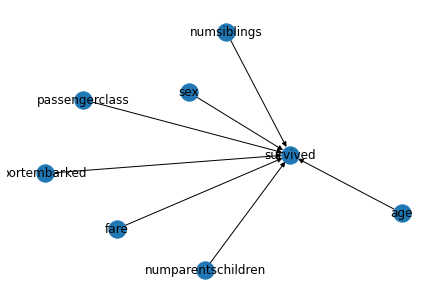

In [59]:
# Define nodes and edges
nodes = ['age', 'portembarked', 'fare', 'numparentschildren', 'passengerclass', 'sex', 'numsiblings','survived']
edges = [('passengerclass', 'survived'), ('sex', 'survived'), ('age', 'survived'), ('fare', 'survived'),
         ('numsiblings', 'survived'), ('numparentschildren', 'survived'), ('portembarked', 'survived')]

# Create directed graph object
G = nx.DiGraph()

# Add nodes to the graph
for node in nodes:
    G.add_node(node)

# Add edges to the graph
G.add_edges_from(edges)

# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

In [43]:
nx.write_graphml(G, 'Bayesian_Model_Titanic.graph')

## Calcule de probabilité

In [10]:
nb_surv_1 = len(data[data['survived'] == 1])
p_surv_1 = nb_surv_1 / 887
print('La probabilité de survived = 1 est: ', p_surv_1)

nb_surv_2 = len(data[data['survived'] == 2])
p_surv_2 = nb_surv_2 / 887
print('La probabilité de survived = 2 est: ', p_surv_2)

La probabilité de survived = 1 est:  0.6189402480270575
La probabilité de survived = 2 est:  0.3833145434047351


#### Probabilite de sex

In [11]:
nb_sex_1 = len(data[data['sex'] == 1]) # nombre de sex=1
p_sex_1 = nb_sex_1 / 887 # probabilite que sex=1
print("probabilite de sex = 1 est: ", p_sex_1)

nb_sex_2 = len(data[data['sex'] == 2]) # nombre de sex=2
p_sex_2 = nb_sex_2 / 887 # probabilite que sex=1
print("probabilite de sex = 2 est: ", p_sex_2)

probabilite de sex = 1 est:  0.6505073280721533
probabilite de sex = 2 est:  0.35174746335963925


#### Probabilite de sex sachant que survived = 1

In [12]:
p_sex_1_surv_1 = len(data[(data['sex'] == 1) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et sex=1
prob = p_sex_1_surv_1 / p_surv_1
print('La probabilite de sex=1 sachant survived = 1 est:', prob)

p_sex_2_surv_1 = len(data[(data['sex'] == 2) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et sex=2
prob2 = p_sex_2_surv_1 / p_surv_1
print('La probabilite de sex=2 sachant survived = 1 est:', prob2)

La probabilite de sex=1 sachant survived = 1 est: 0.8524590163934426
La probabilite de sex=2 sachant survived = 1 est: 0.14754098360655737


#### Probabilite de passengerclass

In [13]:
nb_Pclass_1 = len(data[data['passengerclass'] == 1]) # nombre de Pclass=1
p_Pclass_1 = nb_Pclass_1 / 887 # probabilite que Pclass=1
print("probabilite de Pclasse = 1 est:", p_Pclass_1)

nb_Pclass_2 = len(data[data['passengerclass'] == 2]) # nombre de Pclass=2
p_Pclass_2 = nb_Pclass_2 / 887 # probabilite que Pclass=2
print("probabilite de Pclasse = 2 est:", p_Pclass_2)

nb_Pclass_3 = len(data[data['passengerclass'] == 3]) # nombre de Pclass=3
p_Pclass_3 = nb_Pclass_3 / 887 # probabilite que Pclass=3
print("probabilite de Pclasse = 3 est:", p_Pclass_3)

probabilite de Pclasse = 1 est: 0.5535512965050733
probabilite de Pclasse = 2 est: 0.24126268320180383
probabilite de Pclasse = 3 est: 0.20744081172491544


#### Probabilite de passengerclass sachant survived = 1

In [14]:
p_Pclass_1_surv_1 = len(data[(data['passengerclass'] == 1) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et Pclass=1
prob = p_Pclass_1_surv_1 / p_surv_1
print('La probabilite de Pclass = 1 sachant survived = 1 est:', prob)

p_Pclass_2_surv_1 = len(data[(data['passengerclass'] == 2) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et Pclass=2
prob2 = p_Pclass_2_surv_1 / p_surv_1
print('La probabilite de Pclass = 2 sachant survived = 1 est:', prob2)

p_Pclass_3_surv_1 = len(data[(data['passengerclass'] == 3) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et Pclass=3
prob3 = p_Pclass_3_surv_1 / p_surv_1
print('La probabilite de Pclass = 3 sachant survived = 1 est:', prob3)

La probabilite de Pclass = 1 sachant survived = 1 est: 0.6775956284153006
La probabilite de Pclass = 2 sachant survived = 1 est: 0.14571948998178505
La probabilite de Pclass = 3 sachant survived = 1 est: 0.1766848816029144


#### Probabilite de l' age

In [15]:
nb_age_1 = len(data[data['age'] == 1]) # nombre de age=1
p_age_1 = nb_age_1 / 887 # probabilite que age=1
print("probabilite de age = 1 est:", p_age_1)

nb_age_2 = len(data[data['age'] == 2]) # nombre de age=2
p_age_2 = nb_age_2 / 887 # probabilite que age=2
print("probabilite de age = 2 est:", p_age_2)

nb_age_3 = len(data[data['age'] == 3]) # nombre de age=3
p_age_3 = nb_age_3 / 887 # probabilite que age=3
print("probabilite de age = 3 est:", p_age_3)

probabilite de age = 1 est: 0.3596392333709132
probabilite de age = 2 est: 0.5873731679819617
probabilite de age = 3 est: 0.0552423900789177


#### Probabilite d'age sachant survived = 1

In [16]:
p_age_1_surv_1 = len(data[(data['age'] == 1) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et age=1
prob = p_age_1_surv_1 / p_surv_1
print("La probabilite d'age = 1 sachant survived = 1 est:", prob)

p_age_2_surv_1 = len(data[(data['age'] == 2) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et age=2
prob2 = p_age_2_surv_1 / p_surv_1
print("La probabilite d'age = 2 sachant survived = 1 est:", prob2)

p_age_3_surv_1 = len(data[(data['age'] == 3) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et age=3
prob3 = p_age_3_surv_1 / p_surv_1
print("La probabilite d'age = 3 sachant survived = 1 est:", prob3)

La probabilite d'age = 1 sachant survived = 1 est: 0.3442622950819672
La probabilite d'age = 2 sachant survived = 1 est: 0.5938069216757741
La probabilite d'age = 3 sachant survived = 1 est: 0.06193078324225865


#### Probabilite de fare

In [17]:
nb_fare_1 = len(data[data['fare'] == 1]) # nombre de fare=1
p_fare_1 = nb_fare_1 / 887 # probabilite que fare=1
print("Probabilite de fare = 1 est:", p_fare_1)

nb_fare_2 = len(data[data['fare'] == 2]) # nombre de fare=2
p_fare_2 = nb_fare_2 / 887 # probabilite que fare=2
print("Probabilite de fare = 2 est:", p_fare_2)

nb_fare_3 = len(data[data['fare'] == 3]) # nombre de fare=3
p_fare_3 = nb_fare_3 / 887 # probabilite que fare=3
print("Probabilite de fare = 3 est:", p_fare_3)

Probabilite de fare = 1 est: 0.979706877113867
Probabilite de fare = 2 est: 0.019165727170236752
Probabilite de fare = 3 est: 0.0033821871476888386


#### Probabilite de fare sachant survived = 1

In [18]:
p_fare_1_surv_1 = len(data[(data['fare'] == 1) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et fare=1
prob = p_fare_1_surv_1 / p_surv_1
print('La probabilite de fare = 1 sachant survived = 1 est:', prob)

p_fare_2_surv_1 = len(data[(data['fare'] == 2) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et fare=2
prob2 = p_fare_2_surv_1 / p_surv_1
print('La probabilite de fare = 2 sachant survived = 1 est:', prob2)

p_fare_3_surv_1 = len(data[(data['fare'] == 3) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et fare=3
prob3 = p_fare_3_surv_1 / p_surv_1
print('La probabilite de fare = 3 sachant survived = 1 est:', prob3)

La probabilite de fare = 1 sachant survived = 1 est: 0.9890710382513661
La probabilite de fare = 2 sachant survived = 1 est: 0.01092896174863388
La probabilite de fare = 3 sachant survived = 1 est: 0.0


#### Probabilité de numsiblings

In [19]:
nb_numSib_1 = len(data[data['numsiblings'] == 1]) # nombre de numsib=1
p_numSib_1 = nb_numSib_1 / 887 # probabilite que numsib=1
print("probabilite de numsiblings = 1 est:", p_numSib_1)

nb_numSib_2 = len(data[data['numsiblings'] == 2]) # nombre de numsib=2
p_numSib_2 = nb_numSib_2 / 887 # probabilite que numsib=2
print("probabilite de numsiblings = 2 est:", p_numSib_2)

nb_numSib_3 = len(data[data['numsiblings'] == 3]) # nombre de numsib=3
p_numSib_3 = nb_numSib_3 / 887 # probabilite que numsib=3
print("probabilite de numsiblings = 3 est:", p_numSib_3)

probabilite de numsiblings = 1 est: 0.9503945885005637
probabilite de numsiblings = 2 est: 0.043968432919954906
probabilite de numsiblings = 3 est: 0.007891770011273957


#### Probabilité de numsiblings sachant survived = 1

In [20]:
p_numSib_1_surv_1 = len(data[(data['numsiblings'] == 1) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et numsib=1
prob = p_numSib_1_surv_1 / p_surv_1
print('La probabilite de numsiblings = 1 sachant survived = 1 est:', prob)

p_numSib_2_surv_1 = len(data[(data['numsiblings'] == 2) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et numsib=2
prob2 = p_numSib_2_surv_1 / p_surv_1
print('La probabilite de numsiblings = 2 sachant survived = 1 est:', prob2)

p_numSib_3_surv_1 = len(data[(data['numsiblings'] == 3) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et numsib=3
prob3 = p_numSib_3_surv_1 / p_surv_1
print('La probabilite de numsiblings = 3 sachant survived = 1 est:', prob3)

La probabilite de numsiblings = 1 sachant survived = 1 est: 0.9289617486338798
La probabilite de numsiblings = 2 sachant survived = 1 est: 0.058287795992714025
La probabilite de numsiblings = 3 sachant survived = 1 est: 0.012750455373406192


#### Probabilite de numparenteschildren

In [21]:
nb_numparch_1 = len(data[data['numparentschildren'] == 1]) # nombre de numparch=1
p_numparch_1 = nb_numparch_1 / 887 # probabilite que numparch=1
print("Probabilite de numparentschildren = 1 est:", p_numparch_1)

nb_numparch_2 = len(data[data['numparentschildren'] == 2]) # nombre de numparch=2
p_numparch_2 = nb_numparch_2 / 887 # probabilite que numparch=2
print("Probabilite de numparentschildren = 2 est:", p_numparch_2)

nb_numparch_3 = len(data[data['numparentschildren'] == 3]) # nombre de numparch=3
p_numparch_3 = nb_numparch_3 / 887 # probabilite que numparch=3
print("Probabilite de numparentschildren = 3 est:", p_numparch_3)

Probabilite de numparentschildren = 1 est: 0.895152198421646
Probabilite de numparentschildren = 2 est: 0.09582863585118377
Probabilite de numparentschildren = 3 est: 0.011273957158962795


#### Probabilite de numparentschildren sachant survived = 1

In [23]:
p_numparch_1_surv_1 = len(data[(data['numparentschildren'] == 1) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et numparch=1
prob = p_numparch_1_surv_1 / p_surv_1
print('La probabilite de numparentschildren = 1 sachant survived = 1 est:', prob)

p_numparch_2_surv_1 = len(data[(data['numparentschildren'] == 2) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et numparch=2
prob2 = p_numparch_2_surv_1 / p_surv_1
print('La probabilite de numparentschildren = 2 sachant survived = 1 est:', prob2)

p_numparch_3_surv_1 = len(data[(data['numparentschildren'] == 3) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et numparch=3
prob3 = p_numparch_3_surv_1 / p_surv_1
print('La probabilite de numparentschildren = 3 sachant survived = 1 est:', prob3)

La probabilite de numparentschildren = 1 sachant survived = 1 est: 0.907103825136612
La probabilite de numparentschildren = 2 sachant survived = 1 est: 0.07650273224043716
La probabilite de numparentschildren = 3 sachant survived = 1 est: 0.01639344262295082


#### Probabilite de portembarked

In [24]:
nb_porte_1 = len(data[data['portembarked'] == 1]) # nombre de porte=1
p_porte_1 = nb_porte_1 / 887 # probabilite que porte=1
print("Probabilite de portembarked = 1 est:", p_porte_1)

nb_porte_2 = len(data[data['portembarked'] == 2]) # nombre de porte=2
p_porte_2 = nb_porte_2 / 887 # probabilite que porte=2
print("Probabilite de portembarked = 2 est:", p_porte_2)

nb_porte_3 = len(data[data['portembarked'] == 3]) # nombre de porte=3
p_porte_3 = nb_porte_3 / 887 # probabilite que porte=3
print("probabilite de portembarked = 3 est:", p_porte_3)

Probabilite de portembarked = 1 est: 0.7260428410372041
Probabilite de portembarked = 2 est: 0.18940248027057496
probabilite de portembarked = 3 est: 0.08680947012401354


### Probabilite de portembarked sachant survived = 1

In [25]:
p_porte_1_surv_1 = len(data[(data['portembarked'] == 1) & (data['survived'] == 1)])/887 #probabilite de survie (survived=1) et porte=1
prob = p_porte_1_surv_1 / p_surv_1
print('La probabilite de portembarked = 1 sachant survived = 1 est:', prob)

p_porte_2_surv_1 = len(data[(data['portembarked'] == 2) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et porte=2
prob2 = p_porte_2_surv_1 / p_surv_1
print('La probabilite de portembarked = 2 sachant survived = 1 est:', prob2)

p_porte_3_surv_1 = len(data[(data['portembarked'] == 3) & (data['survived'] == 1)]) / 887 #probabilite de survie (survived=1) et porte=3
prob3 = p_porte_3_surv_1 / p_surv_1
print('La probabilite de portembarked = 3 sachant survived = 1 est:', prob3)

La probabilite de portembarked = 1 sachant survived = 1 est: 0.7777777777777778
La probabilite de portembarked = 2 sachant survived = 1 est: 0.1366120218579235
La probabilite de portembarked = 3 sachant survived = 1 est: 0.08561020036429873


## Classification

### Séparer les données en ensemble d'entraînement et ensemble de test.

In [37]:
features = ['passengerclass', 'sex', 'age', 'numsiblings', 'numparentschildren', 'fare', 'portembarked']
X_train, X_test, y_train, y_test = train_test_split(data[features], data['survived'], test_size=0.3, random_state=42)

### Classification avec le Réseau Bayésien

In [60]:
# Create Bayesian Network object
titanic_bn = BayesianModel(edges)

In [38]:
# Define the probability distributions of the variables using BayesianEstimator
titanic_bn.fit(data, estimator=BayesianEstimator)

In [39]:
# Prédire les étiquettes sur l'ensemble de test
y_pred_bn = titanic_bn.predict(X_test)

print("\nBayesian Network Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_bn))
print("Precision:", precision_score(y_test, y_pred_bn))
print("Recall:", recall_score(y_test, y_pred_bn))
print("F1 Score:", f1_score(y_test, y_pred_bn))

  0%|          | 0/51 [00:00<?, ?it/s]


Bayesian Network Classifier Performance:
Accuracy: 0.8314606741573034
Precision: 0.8315217391304348
Recall: 0.9161676646706587
F1 Score: 0.8717948717948718


### Classification avec l'algorithme de Naive Bayes

In [40]:
classifier = GaussianNB()  
classifier.fit(X_train, y_train)  

GaussianNB()

In [41]:
y_pred_nb = classifier.predict(X_test)

In [42]:
# Calculer les métriques de performance
print("Naive Bayes Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb))
print("Recall:", recall_score(y_test, y_pred_nb))
print("F1 Score:", f1_score(y_test, y_pred_nb))

Naive Bayes Classifier Performance:
Accuracy: 0.8052434456928839
Precision: 0.8323699421965318
Recall: 0.8622754491017964
F1 Score: 0.8470588235294118


### Comparaision entre le réseau bayésien et l'lagorithme de classification naive bayes

#### La Matrice de confusion du Réseau Bayésien

Classification report:
               precision    recall  f1-score   support

           1       0.83      0.92      0.87       167
           2       0.83      0.69      0.75       100

    accuracy                           0.83       267
   macro avg       0.83      0.80      0.81       267
weighted avg       0.83      0.83      0.83       267



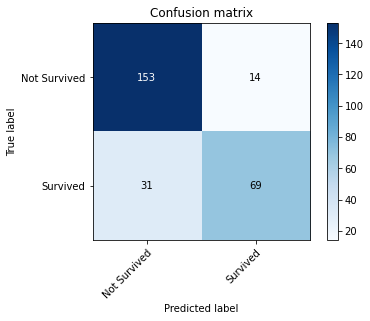

In [46]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_bn)
#print('Confusion matrix:\n', cm)

# Create a classification report
report = classification_report(y_test, y_pred_bn)
print('Classification report:\n', report)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['Not Survived', 'Survived'],
       yticklabels=['Not Survived', 'Survived'],
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black")
fig.colorbar(im)
plt.show()

#### La Matrice de confusion de l'algorithme Naive Bayes

Classification report:
               precision    recall  f1-score   support

           1       0.83      0.86      0.85       167
           2       0.76      0.71      0.73       100

    accuracy                           0.81       267
   macro avg       0.79      0.79      0.79       267
weighted avg       0.80      0.81      0.80       267



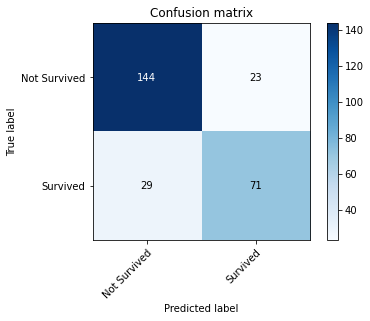

In [47]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)
#print('Confusion matrix:\n', cm)

# Create a classification report
report = classification_report(y_test, y_pred_nb)
print('Classification report:\n', report)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['Not Survived', 'Survived'],
       yticklabels=['Not Survived', 'Survived'],
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black")
fig.colorbar(im)
plt.show()


# Base de donnée: WINE

In [48]:
# Importer la base de données Titanic de Kaggle
wine_data = pd.read_csv('wine.csv')

In [49]:
wine_data.head()

,fixedacidity,volatileacidity,citricacid,residualsugar,chlorides,freesulfurdioxide,totalsulfurdioxide,density,ph,sulphates,alcohol,quality
0,2,1,2,2,1,1,2,2,2,2,1,3
1,2,2,2,1,1,1,2,1,3,2,2,3
2,3,1,2,1,1,1,2,1,3,2,2,3
3,2,1,1,1,1,1,3,1,3,2,2,3
4,2,1,1,1,1,1,3,1,3,2,2,3


## Nombre de DAG possible & Création d'un réseau bayésien

In [ ]:
# Créer une liste des noms des colonnes
columns = data_wine.columns.tolist()

# Initialiser un compteur pour le nombre de DAG possibles
count = 0

# Parcourir toutes les permutations des colonnes
for L in range(0, len(columns)+1):
    for subset in itertools.permutations(columns, L):
        # Vérifier si la permutation est un DAG
        is_dag = True
        for i in range(1, len(subset)):
            for j in range(0, i):
                if subset[j] in data_wine[subset[i]].values:
                    is_dag = False
                    break
            if not is_dag:
                break
        # Incrémenter le compteur si la permutation est un DAG
        if is_dag:
            count += 1

print("Le nombre de DAG possibles est : ", count)


C:\Users\MSI\AppData\Local\Temp\ipykernel_14808\3256195904.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if subset[j] in data_wine[subset[i]].values:


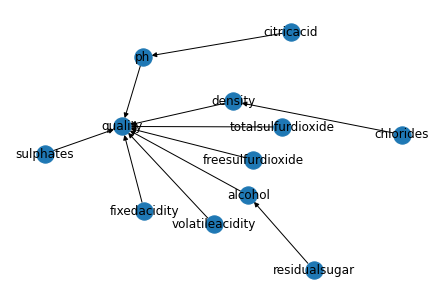

In [61]:
import pandas as pd
from pgmpy.models import BayesianModel
import networkx as nx
import matplotlib.pyplot as plt

# Load the Wine dataset
data = pd.read_csv('wine.csv')

# Define nodes and edges
nodes = ['fixedacidity', 'volatileacidity', 'citricacid', 'residualsugar', 'chlorides', 'freesulfurdioxide'
         , 'totalsulfurdioxide', 'density', 'ph', 'sulphates', 'alcohol', 'quality']

edges = [ ('citricacid', 'ph'),('ph', 'quality'),('freesulfurdioxide', 'quality'),('residualsugar','alcohol')
         ,('alcohol','quality'),('totalsulfurdioxide', 'quality'),('chlorides','density'),('density','quality')
         ,('sulphates', 'quality'),('fixedacidity', 'quality'),('volatileacidity', 'quality')]

# Create directed graph object
G = nx.DiGraph()

# Add nodes to the graph
for node in nodes:
    G.add_node(node)

# Add edges to the graph
G.add_edges_from(edges)

# Draw the graph
nx.draw(G, with_labels=True)
plt.show()


In [101]:
nx.write_graphml(G, 'Bayesian_Model_wine.graph')

## Calcule de probabilité

In [50]:
wine_data['fixedacidity'].describe()

count    4898.000000
mean        2.002246
std         0.445286
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: fixedacidity, dtype: float64

In [51]:
wine_data['quality'].describe()

count    4898.000000
mean        2.880972
std         0.871532
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: quality, dtype: float64

In [52]:
nb_qual_1 = len(wine_data[wine_data['quality'] == 1])
p_qual_1 = nb_qual_1 / len(wine_data['quality'])
print('La probabilité de qualite = 1 est:', p_qual_1)

nb_qual_2 = len(wine_data[wine_data['quality'] == 2])
p_qual_2 = nb_qual_2 / len(wine_data['quality'])
print('La probabilité de qualite = 2 est:', p_qual_2)

nb_qual_3 = len(wine_data[wine_data['quality'] == 3])
p_qual_3 = nb_qual_3 / len(wine_data['quality'])
print('La probabilité de qualite = 3 est:', p_qual_3)

nb_qual_4 = len(wine_data[wine_data['quality'] == 4])
p_qual_4 = nb_qual_4 / len(wine_data['quality'])
print('La probabilité de qualite = 4 est:', p_qual_4)

nb_qual_5 = len(wine_data[wine_data['quality'] == 5])
p_qual_5 = nb_qual_5 / len(wine_data['quality'])
print('La probabilité de qualite = 5 est:', p_qual_5)

La probabilité de qualite = 1 est: 0.03736218864842793
La probabilité de qualite = 2 est: 0.2974683544303797
La probabilité de qualite = 3 est: 0.44875459371171905
La probabilité de qualite = 4 est: 0.17966516945692118
La probabilité de qualite = 5 est: 0.03674969375255206


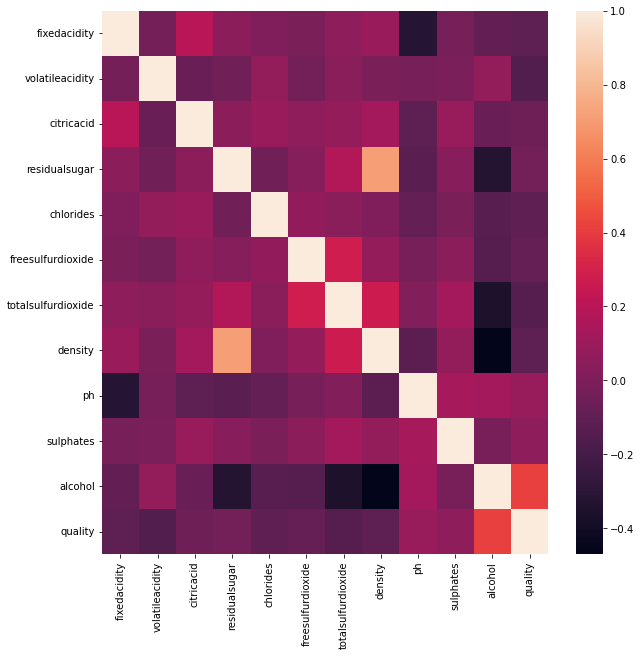

In [55]:
import seaborn as sns
corr_matrix = wine_data.corr()
# plot correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix)
# show plot
plt.show()

P(quality|ph,density,alcohol,totalsulfurdioxide,sulphates,volatileacidity,fixedacidity,freesulfurdioxide) = P(ph,density,alcohol,totalsulfurdioxide,sulphates,volatileacidity,fixedacidity,freesulfurdioxide|quality) * P(Quality) /
P(ph,density,alcohol,totalsulfurdioxide,sulphates,volatileacidity,fixedacidity,freesulfurdioxide)

P(ph,density,residualsugar,totalsulfurdioxide,sulphates,volatileacidity,fixedacidity,freesulfurdioxide|quality) = P(ph|quality) * P(density|quality) * P(sulphates|quality) * P(alcohol|quality) * P(totalsulfurdioxide|quality) * P(volatileacidityvolatileacidity|quality) * P(fixedacidity|quality) * P(freesulfurdioxide|quality)

D'aprés la formule (1) il faut calculer les probabilités conditionnelles suivantes :


P(ph|quality)

P(density|quality)

P(sulphates|quality)

P(alcohol|quality)

P(totalsulfurdioxide|quality)

P(volatileacidityvolatileacidity|quality)

P(fixedacidity|quality)

P(freesulfurdioxide|quality)

In [64]:
# Calcul de P(quality)
quality = wine_data.groupby('quality').size().div(len(wine_data)) 
print(quality)

quality
1    0.037362
2    0.297468
3    0.448755
4    0.179665
5    0.036750
dtype: float64


In [65]:
likelihood = {}
likelihood['ph'] = wine_data.groupby(['quality', 'ph']).size().div(len(wine_data)).div(quality)
likelihood['density'] = wine_data.groupby(['quality', 'density']).size().div(len(wine_data)).div(quality)
likelihood['sulphates'] = wine_data.groupby(['quality', 'sulphates']).size().div(len(wine_data)).div(quality)
likelihood['alcohol'] = wine_data.groupby(['quality', 'alcohol']).size().div(len(wine_data)).div(quality)
likelihood['totalsulfurdioxide'] = wine_data.groupby(['quality', 'totalsulfurdioxide']).size().div(len(wine_data)).div(quality)
likelihood['volatileacidityvolatileacidity'] = wine_data.groupby(['quality', 'volatileacidity']).size().div(len(wine_data)).div(quality)
likelihood['fixedacidity'] = wine_data.groupby(['quality', 'fixedacidity']).size().div(len(wine_data)).div(quality)
likelihood['freesulfurdioxide'] = wine_data.groupby(['quality', 'freesulfurdioxide']).size().div(len(wine_data)).div(quality)
print (likelihood)

{'ph': quality  ph
1        1     0.060109
         2     0.415301
         3     0.393443
         4     0.114754
         5     0.016393
2        1     0.035003
         2     0.450927
         3     0.439259
         4     0.065202
         5     0.009609
3        1     0.035487
         2     0.390355
         3     0.469973
         4     0.093267
         5     0.010919
4        1     0.036364
         2     0.353409
         3     0.447727
         4     0.152273
         5     0.010227
5        2     0.333333
         3     0.505556
         4     0.161111
dtype: float64, 'density': quality  density
1        1          0.852459
         2          0.147541
2        1          0.774880
         2          0.225120
3        1          0.862602
         2          0.136033
         3          0.000910
         5          0.000455
4        1          0.904545
         2          0.095455
5        1          0.905556
         2          0.094444
dtype: float64, 'sulphates': quality 

#### Calcul des variables sans parents

In [97]:
#calcul des variables sans parents 
volatileacidity = wine_data.groupby('volatileacidity').size().div(len(wine_data)) 
fixedacidity = wine_data.groupby('fixedacidity').size().div(len(wine_data)) 
sulphates = wine_data.groupby('sulphates').size().div(len(wine_data)) 
chlorides = wine_data.groupby('chlorides').size().div(len(wine_data)) 
totalsulfurdioxide = wine_data.groupby('totalsulfurdioxide').size().div(len(wine_data)) 
residualsugar = wine_data.groupby('residualsugar').size().div(len(wine_data))
freesulfurdioxide = wine_data.groupby('freesulfurdioxide').size().div(len(wine_data)) 
citricacid = wine_data.groupby('citricacid').size().div(len(wine_data))
print (volatileacidity)
print (fixedacidity)
print(sulphates)
print(chlorides)
print (totalsulfurdioxide) 
print(residualsugar)
print(freesulfurdioxide)
print(citricacid)

volatileacidity
1    0.611474
2    0.350551
3    0.033687
4    0.003062
5    0.001225
dtype: float64
fixedacidity
1    0.096162
2    0.807064
3    0.095345
4    0.001225
5    0.000204
dtype: float64
sulphates
1    0.207023
2    0.580237
3    0.175174
4    0.032666
5    0.004900
dtype: float64
chlorides
1    0.964271
2    0.022050
3    0.011637
4    0.001429
5    0.000612
dtype: float64
totalsulfurdioxide
1    0.149857
2    0.684769
3    0.163332
4    0.001633
5    0.000408
dtype: float64
residualsugar
1    0.888934
2    0.110453
3    0.000408
5    0.000204
dtype: float64
freesulfurdioxide
1    0.921192
2    0.077174
3    0.001429
5    0.000204
dtype: float64
citricacid
1    0.585953
2    0.392813
3    0.019804
4    0.001225
5    0.000204
dtype: float64


#### Calcul de P(density|chlorides)

In [98]:
#calcul de P(density|chlorides)
likelihood1 = {}
likelihood1['density'] = wine_data.groupby(['chlorides', 'density']).size().div(len(wine_data)).div(chlorides)
print(likelihood1)

{'density': chlorides  density
1          1          0.845225
           2          0.154139
           3          0.000423
           5          0.000212
2          1          0.833333
           2          0.166667
3          1          0.912281
           2          0.087719
4          1          0.714286
           2          0.285714
5          1          0.333333
           2          0.666667
dtype: float64}


#### Calcul de P(alcohol|residualsugar)

In [99]:
#calcul de P(alcohol|residualsugar)
likelihood2 = {}
likelihood2['alcohol'] = wine_data.groupby(['residualsugar', 'alcohol']).size().div(len(wine_data)).div(residualsugar)
print(likelihood2)

{'alcohol': residualsugar  alcohol
1              1          0.118741
               2          0.359669
               3          0.311897
               4          0.178686
               5          0.031006
2              1          0.602588
               2          0.303142
               3          0.057301
               4          0.031423
               5          0.005545
3              1          1.000000
5              3          1.000000
dtype: float64}


#### Calcul de P(ph|citricacid)

In [100]:
#calcul de P(ph|citricacid)
likelihood3 = {}
likelihood3['ph'] = wine_data.groupby(['citricacid', 'ph']).size().div(len(wine_data)).div(citricacid)
print(likelihood3)

{'ph': citricacid  ph
1           1     0.030662
            2     0.367944
            3     0.472822
            4     0.114634
            5     0.013937
2           1     0.038981
            2     0.440229
            3     0.440229
            4     0.075884
            5     0.004678
3           1     0.092784
            2     0.577320
            3     0.226804
            4     0.092784
            5     0.010309
4           2     0.500000
            3     0.500000
5           3     1.000000
dtype: float64}


## Classification

### Séparer les données en ensemble d'entraînement et ensemble de test.

In [71]:
features = ['fixedacidity', 'volatileacidity', 'citricacid', 'residualsugar', 'chlorides', 'freesulfurdioxide', 'totalsulfurdioxide',
           'density', 'ph', 'sulphates', 'alcohol']
X_train, X_test, y_train, y_test = train_test_split(wine_data[features], wine_data['quality'], test_size=0.3, random_state=42)

### Classification avec le Réseau Bayésien

In [72]:
# Create Bayesian Network object
wine_bn = BayesianModel(edges)

C:\Users\MSI\anaconda3\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


In [73]:
# Define the probability distributions of the variables using BayesianEstimator
wine_bn.fit(wine_data, estimator=BayesianEstimator)

In [75]:
# Prédire les étiquettes sur l'ensemble de test
y_pred_bn = wine_bn.predict(X_test)

print("\nBayesian Network Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_bn))
print("Precision:", precision_score(y_test, y_pred_bn, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_bn, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_bn, average='weighted'))

  0%|          | 0/677 [00:00<?, ?it/s]


Bayesian Network Classifier Performance:
Accuracy: 0.6605442176870748
Precision: 0.6709592875848862
Recall: 0.6605442176870748
F1 Score: 0.6497182087816809


### Classification avec l'algorithme de Naive Bayes

In [79]:
classifier = GaussianNB()  
classifier.fit(X_train, y_train)  

GaussianNB()

In [80]:
y_pred_nb = classifier.predict(X_test)

In [81]:
# Calculer les métriques de performance
print("Naive Bayes Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_bn, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_bn, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_bn, average='weighted'))

Naive Bayes Classifier Performance:
Accuracy: 0.3081632653061224
Precision: 0.6709592875848862
Recall: 0.6605442176870748
F1 Score: 0.6497182087816809


### Comparaision entre le réseau bayésien et l'lagorithme de classification naive bayes

#### La Matrice de confusion du Réseau Bayésien

Classification report:
               precision    recall  f1-score   support

           1       0.63      0.51      0.56        47
           2       0.71      0.62      0.66       426
           3       0.63      0.81      0.71       668
           4       0.68      0.46      0.55       280
           5       0.85      0.22      0.35        49

    accuracy                           0.66      1470
   macro avg       0.70      0.53      0.57      1470
weighted avg       0.67      0.66      0.65      1470



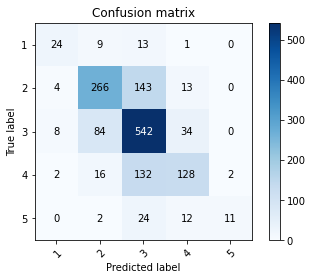

In [91]:
# Create a confusion matrix
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_bn, labels=labels)
#print('Confusion matrix:\n', cm)

# Create a classification report
report = classification_report(y_test, y_pred_bn)
print('Classification report:\n', report)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(len(labels)),
       yticks=np.arange(len(labels)),
       xticklabels=labels,
       yticklabels=labels,
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black")
fig.colorbar(im)
plt.show()


#### La Matrice de confusion de l'algorithme Naive Bayes

Classification report:
               precision    recall  f1-score   support

           1       0.22      0.15      0.18        47
           2       0.47      0.38      0.42       426
           3       0.46      0.09      0.15       668
           4       0.24      0.80      0.36       280
           5       0.00      0.00      0.00        49

    accuracy                           0.31      1470
   macro avg       0.28      0.28      0.22      1470
weighted avg       0.40      0.31      0.26      1470



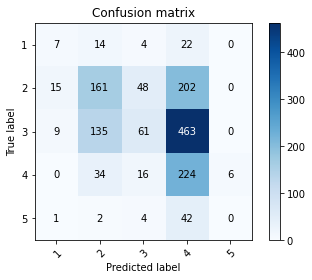

In [90]:
# Create a confusion matrix
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_nb, labels=labels)
#print('Confusion matrix:\n', cm)

# Create a classification report
report = classification_report(y_test, y_pred_nb)
print('Classification report:\n', report)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(len(labels)),
       yticks=np.arange(len(labels)),
       xticklabels=labels,
       yticklabels=labels,
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black")
fig.colorbar(im)
plt.show()
